### 라이브러리와 모듈을 임포트

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import lightgbm as lgb
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier


### Read dataset files

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
# 결측치 개수 확인
print("Train 데이터 결측치 개수:")
print(train_df.isnull().sum())

print("\nTest 데이터 결측치 개수:")
print(test_df.isnull().sum())

Train 데이터 결측치 개수:
index              0
name               0
birth              0
bp_high            0
bp_low             0
chol_good          0
chol_bad           0
iron_lvl           0
creatinine         0
urine_marker       0
sugar_lvl          0
lipid_lvl          0
fat_content        0
oral_issues        0
stature_inch       0
mass_kg            0
midsection_inch    0
immune_index       0
enzyme_1           0
enzyme_2           0
enzyme_3           0
vision_l           0
vision_r           0
audio_l            0
audio_r            0
health_status      0
dtype: int64

Test 데이터 결측치 개수:
index              0
name               0
birth              0
bp_high            0
bp_low             0
chol_good          0
chol_bad           0
iron_lvl           0
creatinine         0
urine_marker       0
sugar_lvl          0
lipid_lvl          0
fat_content        0
oral_issues        0
stature_inch       0
mass_kg            0
midsection_inch    0
immune_index       0
enzyme_1           0
enzyme

### Train 데이터 feature engineering

In [3]:
X = train_df.drop(columns=['health_status', 'name', 'index'])  # 불필요한 열 제외
y = train_df['health_status']  # 정답 데이터 (타겟 변수)

X = X.drop(columns=['audio_l', 'audio_r'])  # 좌/우 오디오 데이터 열 제외

# 현재 나이 계산
current_year = 2024
X['age'] = current_year - X['birth']  # 출생 연도를 기반으로 나이를 계산하여 추가

# 연령대 그룹화: A(0~39), B(40~59), C(60~79)
X['age_group'] = X['age'].apply(lambda x: 'A' if x < 41 else ('B' if x < 61 else 'C'))  

# 연령대 원-핫 인코딩 수행
one_hot_age = pd.get_dummies(X['age_group'], prefix='age_group')  # 연령대 그룹을 원-핫 인코딩
X = pd.concat([X, one_hot_age], axis=1)  # 원래 데이터프레임에 인코딩된 열 추가
X = X.drop(columns=['age_group', 'age'])  # 원래의 연령대 및 나이 열 삭제 (성능 저하를 막기 위해 age는 남길 수도 있음)

# 소변 마커 'urine_marker' 열에 대해 원-핫 인코딩 수행
X = pd.get_dummies(X, columns=['urine_marker'])  
# 소변 마커 urine_marker 중 특정 열(6번 마커) 삭제
columns_to_drop = ['urine_marker_6']  
X = X.drop(columns=columns_to_drop, errors='ignore')  # 해당 열 삭제 (없는 경우 오류 무시)

# 'oral_issues'와 'bp_high'를 곱해 새로운 특징 생성
X['oral_issues_bp_high'] = X['oral_issues'] * X['bp_high']  # 구강 문제와 고혈압 데이터를 곱한 새로운 특징 생성
X = X.drop(columns=['oral_issues'])  # 기존 구강 문제 열 삭제

# 허리-키 비율 계산
X['waist_height_ratio'] = X['midsection_inch'] / X['stature_inch']  # 허리 둘레와 키를 이용해 비율 계산
X = X.drop(columns=['midsection_inch'])  # 허리 둘레 열 삭제

# 'immune_index' 열 제거
X = X.drop(columns=['immune_index'])  # 면역 지수 데이터 삭제

In [4]:
X_columns = X.columns
X_columns

Index(['birth', 'bp_high', 'bp_low', 'chol_good', 'chol_bad', 'iron_lvl',
       'creatinine', 'sugar_lvl', 'lipid_lvl', 'fat_content', 'stature_inch',
       'mass_kg', 'enzyme_1', 'enzyme_2', 'enzyme_3', 'vision_l', 'vision_r',
       'age_group_A', 'age_group_B', 'age_group_C', 'urine_marker_1',
       'urine_marker_2', 'urine_marker_3', 'urine_marker_4', 'urine_marker_5',
       'oral_issues_bp_high', 'waist_height_ratio'],
      dtype='object')

### Test 데이터 피처 엔지니어링

In [5]:
# test 데이터 전처리
X_test = test_df.drop(columns=['name', 'index'])  # 테스트 데이터에서 불필요한 열(name, index) 제외
X_test = X_test.drop(columns=['audio_l', 'audio_r'])  # 좌/우 오디오 데이터 열 제외

# 현재 나이 계산
current_year = 2024
X_test['age'] = current_year - X_test['birth']  # 출생 연도를 기반으로 나이를 계산하여 추가

# 연령대 그룹화: A(0~39), B(40~59), C(60~79)
X_test['age_group'] = X_test['age'].apply(lambda x: 'A' if x < 41 else ('B' if x < 61 else 'C')) 

# 연령대 원-핫 인코딩 수행
one_hot_age = pd.get_dummies(X_test['age_group'], prefix='age_group')  # 연령대 그룹을 원-핫 인코딩
X_test = pd.concat([X_test, one_hot_age], axis=1)  # 원래 데이터프레임에 인코딩된 열 추가
X_test = X_test.drop(columns=['age_group', 'age'])  # 원래의 연령대 및 나이 열 삭제

# 소변 마커 데이터 'urine_marker' 열에 대해 원-핫 인코딩 수행
X_test = pd.get_dummies(X_test, columns=['urine_marker'])  

#  소변 마커 urine_marker 중 특정 열(6번 마커) 삭제
columns_to_drop = ['urine_marker_6'] 
X_test = X_test.drop(columns=columns_to_drop, errors='ignore')  # 해당 열 삭제 (없는 경우 오류 무시)

# 'oral_issues'와 'bp_high'를 곱해 새로운 특징 생성
X_test['oral_issues_bp_high'] = X_test['oral_issues'] * X_test['bp_high']  # 구강 문제와 고혈압 데이터를 곱한 새로운 특징 생성
X_test = X_test.drop(columns=['oral_issues'])  # 기존 구강 문제 열 삭제

# 허리-키 비율 계산
X_test['waist_height_ratio'] = X_test['midsection_inch'] / X_test['stature_inch']  # 허리 둘레와 키를 이용해 비율 계산
X_test = X_test.drop(columns=['midsection_inch'])  # 허리 둘레 열 삭제

# 'immune_index' 열 제거
X_test = X_test.drop(columns=['immune_index'])  # 면역 지수 데이터 삭제


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y 
)


# 데이터 크기확인
print("훈련 데이터 크기:", X_train.shape, y_train.shape)
print("검증 데이터 크기:", X_valid.shape, y_valid.shape)

훈련 데이터 크기: (112000, 27) (112000,)
검증 데이터 크기: (28000, 27) (28000,)


## Make Model & Train
### Stacking Ensemble
- **XGBoost**
- **LightGBM**
- **GradientBoosting**


>StratifiedKFold 설정 및 교차 검증


In [ ]:
# StratifiedKFold 설정
n_splits = 5  # 분할 수
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 결과 저장
xgb_auc_scores = []
lgb_auc_scores = []
gb_auc_scores = []
stack_auc_scores = []

### XGBoost

In [8]:
#pip install xgboost


In [9]:
# XGBoost 모델 교차 검증
for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}/{n_splits} - XGBoost")
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    xgb_model = XGBClassifier(
        n_estimators=2300,
        max_depth=5,
        learning_rate=0.056912715,
        subsample=0.961071738,
        colsample_bytree=0.25178034,
        min_child_weight=10,
        random_state=40,
        n_jobs=-1
    )

    xgb_model.fit(X_train, y_train)
    y_pred_proba = xgb_model.predict_proba(X_valid)[:, 1]
    auc_score = roc_auc_score(y_valid, y_pred_proba)
    xgb_auc_scores.append(auc_score)
    print(f"Fold {fold + 1} AUC (XGBoost): {auc_score:.4f}")

Fold 1/5 - XGBoost
Fold 1 AUC (XGBoost): 0.8691
Fold 2/5 - XGBoost
Fold 2 AUC (XGBoost): 0.8703
Fold 3/5 - XGBoost
Fold 3 AUC (XGBoost): 0.8721
Fold 4/5 - XGBoost
Fold 4 AUC (XGBoost): 0.8704
Fold 5/5 - XGBoost
Fold 5 AUC (XGBoost): 0.8715


### LightGBM

In [10]:
# LightGBM 모델 교차 검증
for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}/{n_splits} - LightGBM")
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    lgb_model = lgb.LGBMClassifier(
        n_estimators=1100,
        max_depth=5,
        colsample_bytree=0.1,
        reg_lambda=10,
        subsample_for_bin=200000,
        num_leaves=200,
        random_state=40,
        n_jobs=-1
    )

    lgb_model.fit(X_train, y_train)
    y_pred_proba = lgb_model.predict_proba(X_valid)[:, 1]
    auc_score = roc_auc_score(y_valid, y_pred_proba)
    lgb_auc_scores.append(auc_score)
    print(f"Fold {fold + 1} AUC (LightGBM): {auc_score:.4f}")

Fold 1/5 - LightGBM
[LightGBM] [Info] Number of positive: 49053, number of negative: 62947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2224
[LightGBM] [Info] Number of data points in the train set: 112000, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437973 -> initscore=-0.249392
[LightGBM] [Info] Start training from score -0.249392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

### GradientBoosting

In [11]:
# GradientBoosting 모델 교차 검증
for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}/{n_splits} - GradientBoosting")
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    gb_model = GradientBoostingClassifier(
        n_estimators=1100,
        max_depth=5,
        learning_rate=0.1,
        random_state=40
    )

    gb_model.fit(X_train, y_train)
    y_pred_proba = gb_model.predict_proba(X_valid)[:, 1]
    auc_score = roc_auc_score(y_valid, y_pred_proba)
    gb_auc_scores.append(auc_score)
    print(f"Fold {fold + 1} AUC (GradientBoosting): {auc_score:.4f}")


Fold 1/5 - GradientBoosting
Fold 1 AUC (GradientBoosting): 0.8646
Fold 2/5 - GradientBoosting
Fold 2 AUC (GradientBoosting): 0.8669
Fold 3/5 - GradientBoosting
Fold 3 AUC (GradientBoosting): 0.8678
Fold 4/5 - GradientBoosting
Fold 4 AUC (GradientBoosting): 0.8658
Fold 5/5 - GradientBoosting
Fold 5 AUC (GradientBoosting): 0.8681


### Stacking Ensemble

In [12]:
# 스태킹 모델 설정
meta_model = LogisticRegression(max_iter=1000, solver='liblinear')
stacking_ensemble = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('gb', gb_model)
    ],
    final_estimator=meta_model,
    stack_method='predict_proba',
    n_jobs=-1
)

# 스태킹 모델 교차 검증
for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}/{n_splits} - Stacking")
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    stacking_ensemble.fit(X_train, y_train)
    y_pred_proba = stacking_ensemble.predict_proba(X_valid)[:, 1]
    auc_score = roc_auc_score(y_valid, y_pred_proba)
    stack_auc_scores.append(auc_score)
    print(f"Fold {fold + 1} AUC (Stacking): {auc_score:.4f}")

# 결과 출력
print(f"Mean AUC (XGBoost): {np.mean(xgb_auc_scores):.4f}")
print(f"Mean AUC (LightGBM): {np.mean(lgb_auc_scores):.4f}")
print(f"Mean AUC (GradientBoosting): {np.mean(gb_auc_scores):.4f}")
print(f"Mean AUC (Stacking): {np.mean(stack_auc_scores):.4f}")


Fold 1/5 - Stacking
Fold 1 AUC (Stacking): 0.8702
Fold 2/5 - Stacking
Fold 2 AUC (Stacking): 0.8712
Fold 3/5 - Stacking
Fold 3 AUC (Stacking): 0.8729
Fold 4/5 - Stacking
Fold 4 AUC (Stacking): 0.8710
Fold 5/5 - Stacking
Fold 5 AUC (Stacking): 0.8726
Mean AUC (XGBoost): 0.8707
Mean AUC (LightGBM): 0.8705
Mean AUC (GradientBoosting): 0.8666
Mean AUC (Stacking): 0.8716


### Feature Importance Visualization (특징 중요도 시각화)


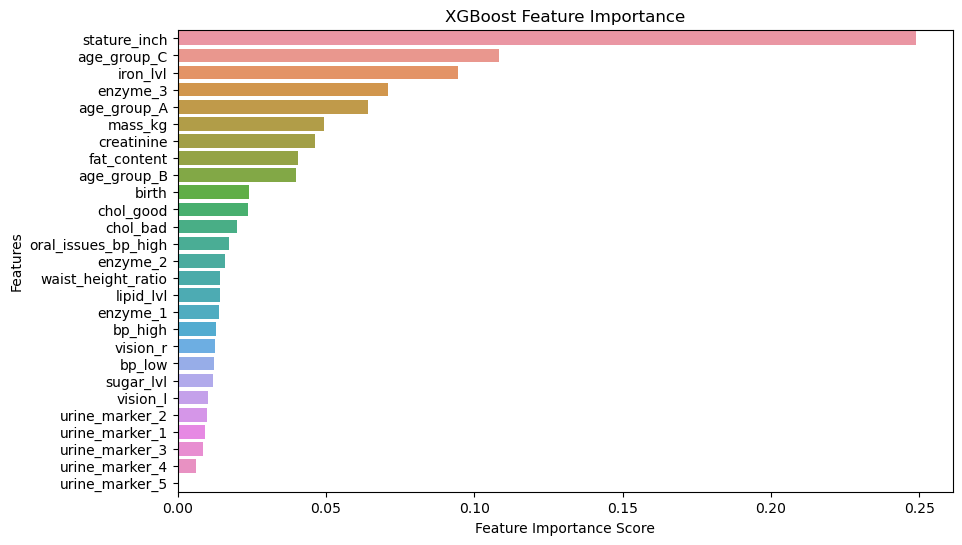

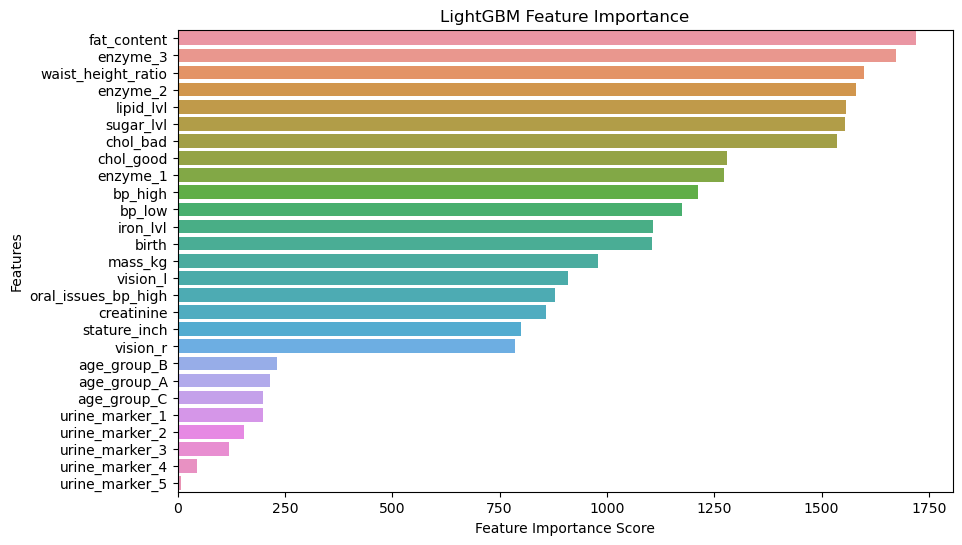

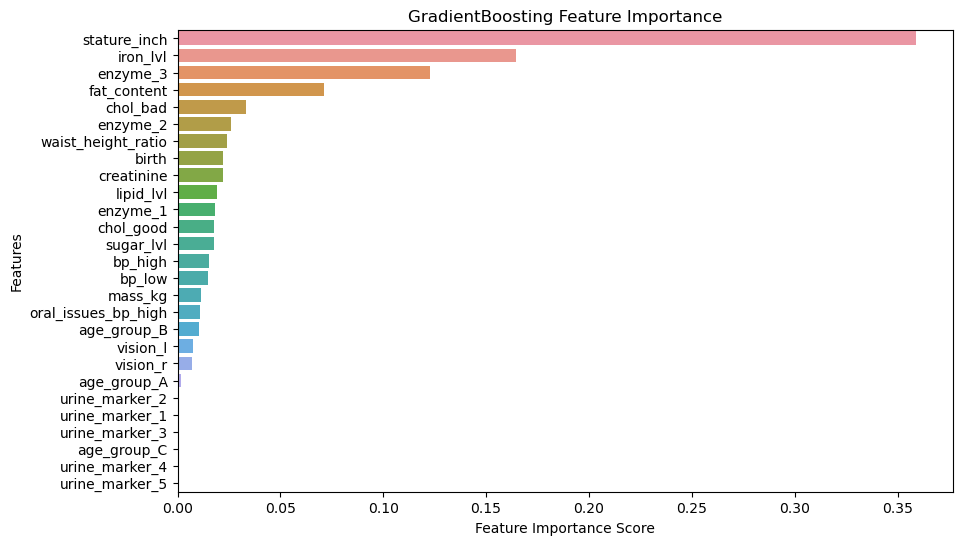

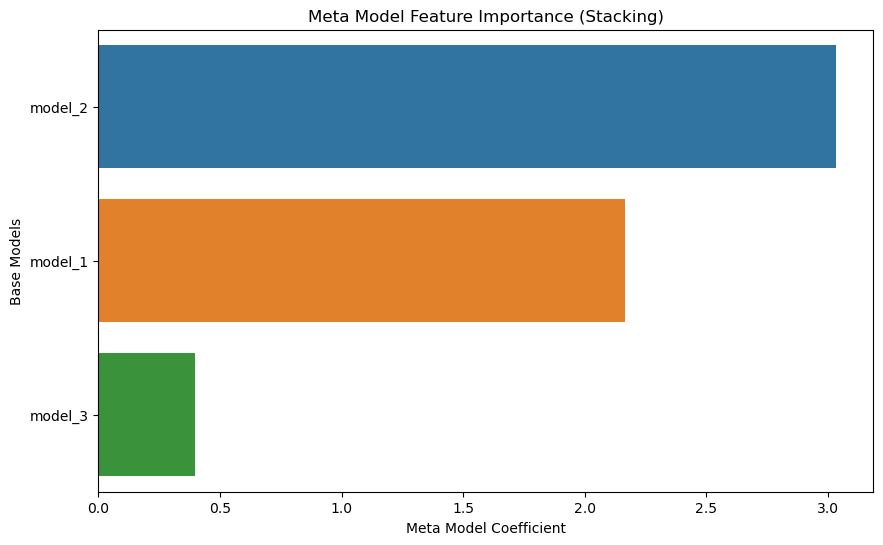

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# XGBoost 중요도
xgb_feature_scores = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# LightGBM 중요도
lgbm_feature_scores = pd.Series(lgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# GradientBoosting 중요도
gb_feature_scores = pd.Series(gb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# 시각화: XGBoost
plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_feature_scores, y=xgb_feature_scores.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')
plt.show()

# 시각화: LightGBM
plt.figure(figsize=(10, 6))
sns.barplot(x=lgbm_feature_scores, y=lgbm_feature_scores.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('LightGBM Feature Importance')
plt.show()

# 시각화: GradientBoosting
plt.figure(figsize=(10, 6))
sns.barplot(x=gb_feature_scores, y=gb_feature_scores.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('GradientBoosting Feature Importance')
plt.show()

# StackingClassifier의 메타 모델 중요도 계산
meta_model = stacking_ensemble.final_estimator_
base_model_names = [f"model_{i+1}" for i in range(len(stacking_ensemble.estimators_))]

# LogisticRegression 메타 모델의 중요도
if hasattr(meta_model, 'coef_'):  # LogisticRegression일 경우
    meta_importance = pd.Series(meta_model.coef_[0], index=base_model_names).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=meta_importance, y=meta_importance.index)
    plt.xlabel('Meta Model Coefficient')
    plt.ylabel('Base Models')
    plt.title('Meta Model Feature Importance (Stacking)')
    plt.show()
else:
    print("Stacking 메타 모델은 LogisticRegression이 아니거나 중요도 계산을 지원하지 않음")




> 모델별 중요도 3개를 한번에 표시하여 비교  
> 모델별 특징 중요도 값의 크기 차이가 커서 특정 모델의 중요도가 다른 모델을 압도하는 현상이 발생함.  
>이를 해결하기 위해 정규화(Normalization)를 사용하여 모든 모델의 중요도를 동일한 범위(0~1)로 맞추면 그래프에서 중요도를 균형 있게 비교할 수 있음

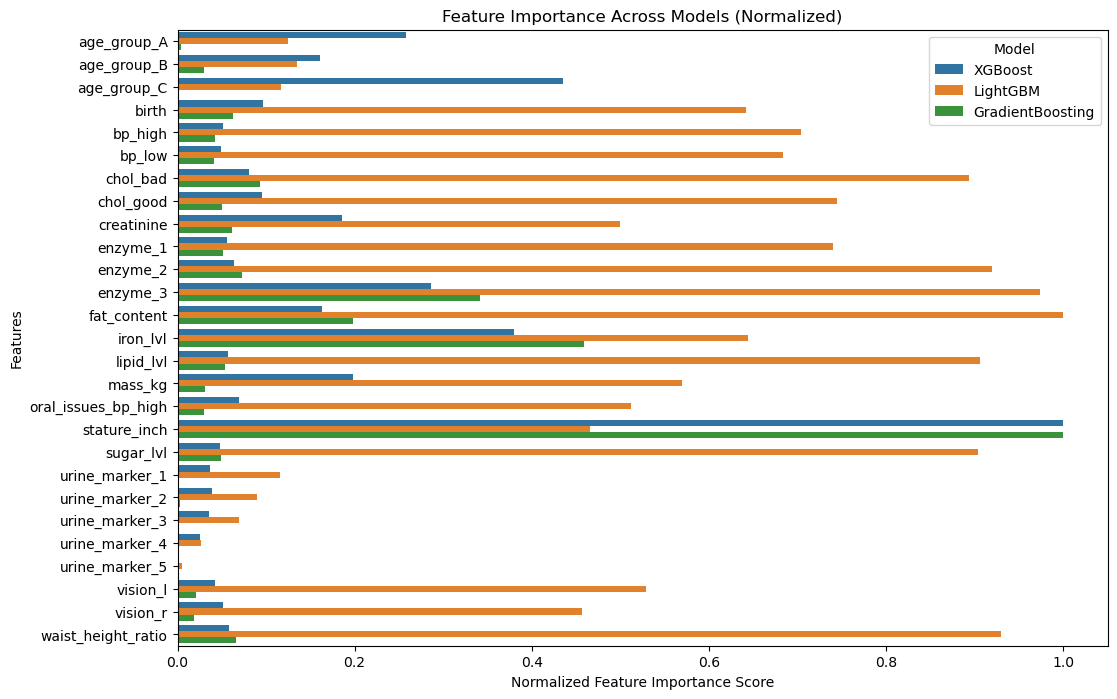

In [32]:
# 세 모델의 중요도를 하나의 DataFrame으로 결합하고 정규화
feature_importances = pd.DataFrame({
    'XGBoost': xgb_feature_scores,
    'LightGBM': lgbm_feature_scores,
    'GradientBoosting': gb_feature_scores
}).reset_index()

# 정규화
feature_importances[['XGBoost', 'LightGBM', 'GradientBoosting']] = feature_importances[['XGBoost', 'LightGBM', 'GradientBoosting']].apply(lambda x: x / x.max())

# 변환된 데이터를 Melt 형태로 변환
feature_importances = feature_importances.melt(id_vars='index', var_name='Model', value_name='Importance')

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importances, x='Importance', y='index', hue='Model')
plt.xlabel('Normalized Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance Across Models (Normalized)')
plt.legend(title='Model')
plt.show()



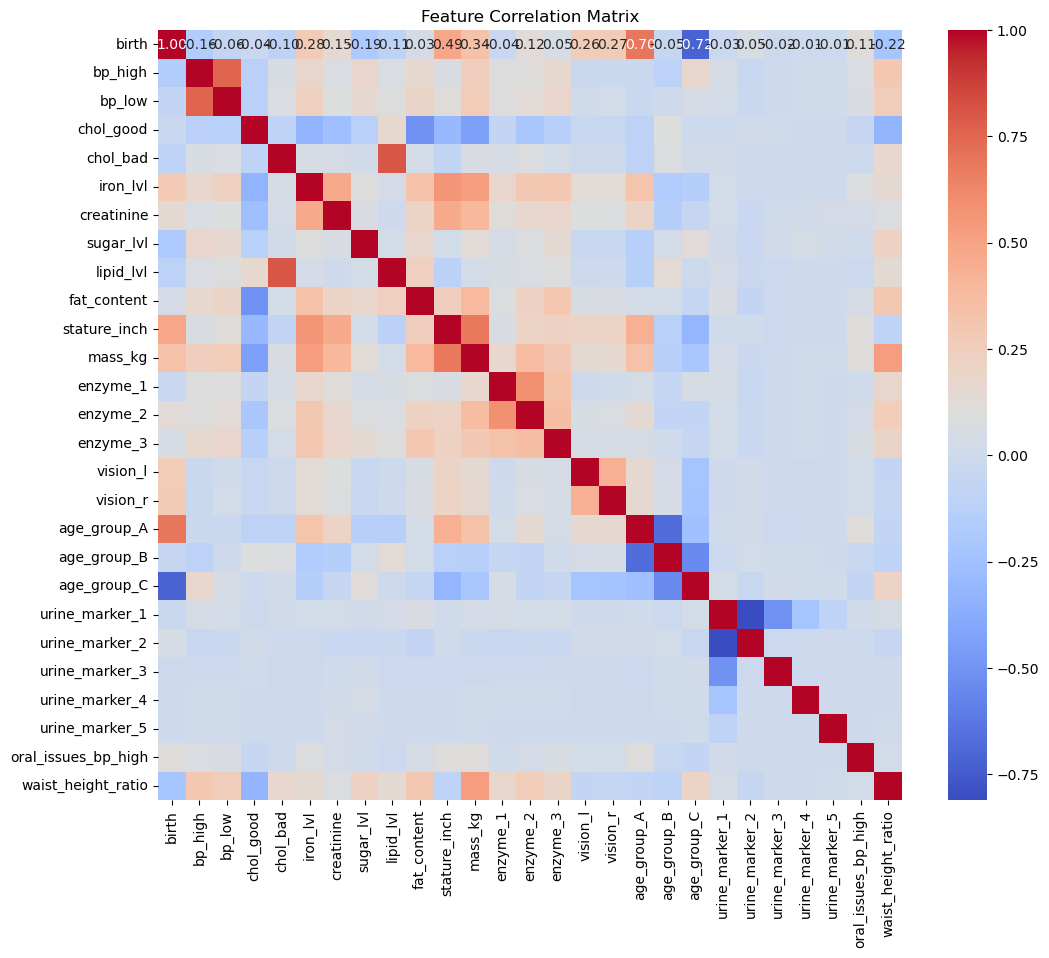

In [34]:
# 상관 관계 매트릭스 계산
correlation_matrix = X_train.corr()

# 상관 관계가 높은 피처 시각화
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

### Make test prediction

In [35]:
# positive일 확률을 저장
test_prob = stacking_ensemble.predict_proba(X_test)[:, 1]


### Export prediction to file

In [ ]:
# 제출 파일 저장
submission_df = pd.read_csv('sample_submission.csv')
submission_df.health_status = test_prob 
submission_df.to_csv('submission_RF1210_StratifiedKFold.csv', index=False)